In [81]:
# Import libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

In [82]:
# Load data
df = pd.read_csv('SMDG_results.csv')

# Remove rows with missing values
df = df.dropna()

# Remove rows where glaucoma is not 0 or 1
# df = df[df['glaucoma'].isin([0, 1])]

# Remove unnecesary columns
keep = ['filename', 'glaucoma'] + [col for col in df.columns if 'pcdr_' in col]
df = df[keep]

# Keep only rows with filename starting with 'ORIGA'
df = df[df['filename'].str.startswith('ORIGA')]

# Cap pcdr_ values to 1
df[df.iloc[:, 2:] > 1] = 1

# Keep only rows that have pcdr_ values (lb, ub]
lb = 0 ; ub = 1
df = df[(df.iloc[:, 2:] <= lb).any(axis=1).__invert__() & (df.iloc[:, 2:] > ub).any(axis=1).__invert__()]

# Remove rows with all pcdr_ values equal to 1
df = df[(df.iloc[:, 2:] == 1).all(axis=1).__invert__()]

# Split data into train and test
seed = np.random.randint(0, 10000)
np.random.seed(seed)
train = df.sample(frac=0.7)
test = df.drop(train.index)
print('Train:', train.shape[0])
print('Test:', test.shape[0])
print('#############################################')
print('Images suitable for analysis:', df.shape[0])
print('Glaucoma:', (df['glaucoma'] == 1).sum())
print('Non glaucoma:', (df['glaucoma'] == 0).sum())
print('Glaucoma-suspect:', (df['glaucoma'] == -1).sum())

Train: 421
Test: 181
#############################################
Images suitable for analysis: 602
Glaucoma: 141
Non glaucoma: 461
Glaucoma-suspect: 0


**Disclaimer**

- Disc, cup and fovea segmentations are done using segmentation CNNs. Very useful for large batches of data but can generate some weird segmentations, especially in low quality fundus images.

**Excluding rules**

- All pCDR values == 1: ellipses fitted to cup and disc segmentations are equal or almost equal.
  
- pCDR values very low: generally caused by the disc segmentation not being great (disc surrounding tissue, pathology near disc, disc edge barely visible...).
  
- pCDR values > 1: disc and cup ellipses are very very close together and, mathematically, the calculation of the intersection points leads to the cup_points going over the disc_points.

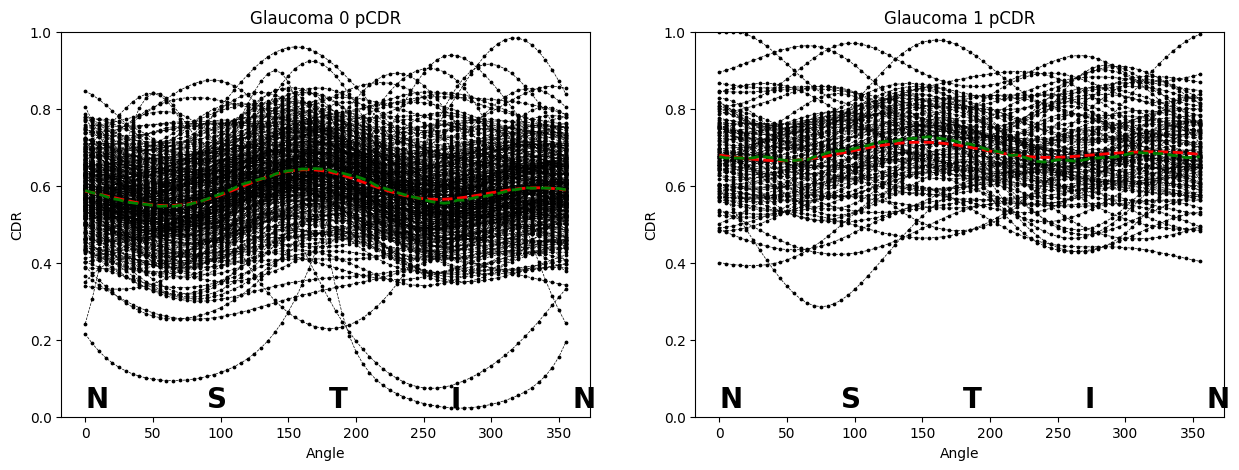

In [83]:
# Group by glaucoma status
df_grouped = train.groupby('glaucoma')

# Plot pcdr values
plt.figure(figsize=(15, 5))
# Number of groups to plot
n_groups = len(df_grouped)
for i, (name, group) in enumerate(df_grouped):
    plt.subplot(1, n_groups, i + 1)
    group = group.drop(['filename', 'glaucoma'], axis=1)
    cdr = group.values.T
    angles = [int(col.split('_')[1]) for col in group.columns if col.startswith('pcdr_')]
    angles = np.tile(angles, (cdr.shape[1], 1)).T # Make angles same shape as cdr for plotting
    plt.plot(angles, cdr, 'k--', linewidth=0.5)
    plt.scatter(angles, cdr, s=3, c='k')
    
    # Plot mean and median
    mean_cdr = np.mean(cdr, axis=1)
    median_cdr = np.median(cdr, axis=1)
    plt.plot(angles[:, 0], mean_cdr, 'r--', linewidth=2)
    plt.plot(angles[:, 0], median_cdr, 'g--', linewidth=2)
    
    # Overlay N S T I N labels on top of the X axis
    angle = [0, 90, 180, 270, 360]
    quadrant = ['N', 'S', 'T', 'I', 'N']
    for a, q in zip(angle, quadrant):
        plt.text(a, 0.025, q, fontsize=20, color='k', fontweight='bold')
    
    plt.title(f'Glaucoma {name} pCDR')
    plt.xlabel('Angle')
    plt.ylabel('CDR')
    plt.ylim(0, 1)
    
plt.show()

In [84]:
# Define method to calculate Mahalanobis distance
def mahalanobis(x, mu, cov):
    """
    Calculate Mahalanobis distance between two vectors x and mu using covariance matrix cov.
    
    Parameters
    ----------
    x : (N,M) array_like
        Input array.
    mu : (N,) array_like
        Mean vector of the distribution.
    cov : (N,N) array_like
        Covariance matrix of the distribution.
        
    """
    
    inv_cov = np.linalg.inv(cov)
    delta = x - mu
    m = np.dot(np.dot(delta, inv_cov), delta.T)
    out = np.sqrt(m)
    return out

# Calculate Mahalanobis distance for each group
cov_matrices = {}
mean_vectors = {}
for name, group in df_grouped:
    # Covariance matrix
    cov = np.cov(group.iloc[:, 2:].values.T)
    # Add covariance matrix to dictionary
    cov_matrices.update({name: cov})
    # Add mean vector to dictionary
    mean_vectors.update({name: np.mean(group.iloc[:, 2:].values, axis=0)})

Prior probability of glaucoma: 0.2375296912114014
#############################################
Log prior odds: -1.1662709371419246
Posterior odds information
count       166.000000
mean       2759.633123
std       35551.706510
min           0.000000
25%           0.037932
50%           0.132311
75%           0.297761
max      458051.982055
Name: log_posterior_odds, dtype: float64


/tmp/ipykernel_6511/2814650398.py:20: RuntimeWarning: invalid value encountered in sqrt
  out = np.sqrt(m)
/tmp/ipykernel_6511/2814650398.py:20: RuntimeWarning: invalid value encountered in sqrt
  out = np.sqrt(m)
/home/borja/anaconda3/envs/superrempe/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Posterior probability of patients (test set)')

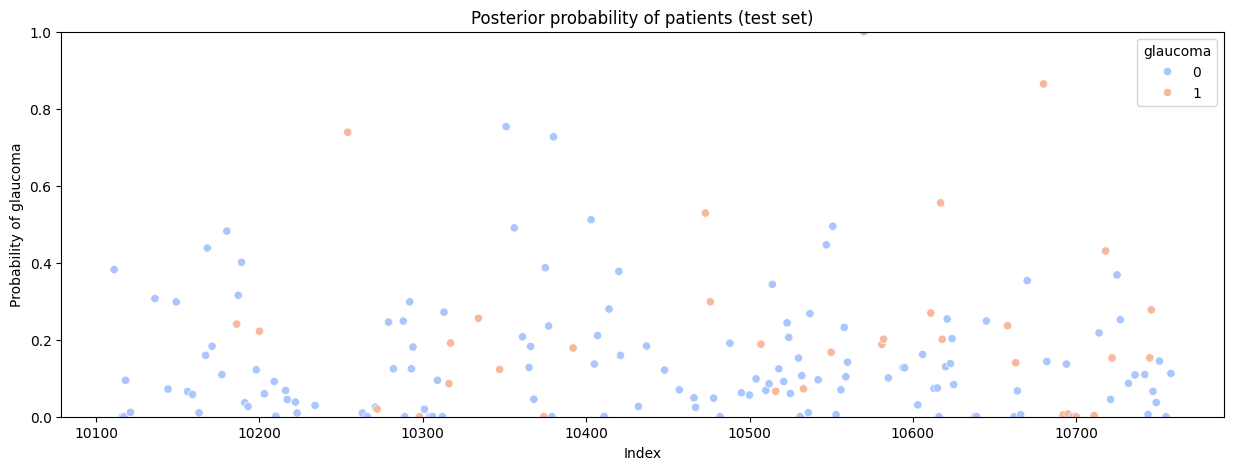

In [85]:
# Calculate Mahalanobis distance on test for each group
test2 = pd.DataFrame(index=test.index)
for k, v in cov_matrices.items():
    mu = mean_vectors.get(k)
    x = test.iloc[:, 2:].values
    mahal = mahalanobis(x=x, mu=mu, cov=v)
    # Add Mahalanobis distance to test2
    col_name = f'mahalanobis_{k}'
    test2[col_name] = mahal.diagonal()
    
# Prior probability of glaucoma
prior_glaucoma = (train['glaucoma'] == 1).sum() / train.shape[0] # ((train['glaucoma'] == 1).sum() + (train['glaucoma'] == 0).sum())
print('Prior probability of glaucoma:', prior_glaucoma)
print('#############################################')

# log(posterior odds) = log(prior odds) + 0.5 * (mahalanobis_0 - mahalanobis_1)
DDI = test2['mahalanobis_0'] - test2['mahalanobis_1']
log_prior_odds = np.log(prior_glaucoma / (1 - prior_glaucoma))
test2['log_posterior_odds'] = log_prior_odds + 0.5 * DDI
# Print DDI distribution information
print(f'Log prior odds: {log_prior_odds}')
# Posterior odds information
print('Posterior odds information')
print(np.exp(test2['log_posterior_odds']).describe())

# Posterior probability of glaucoma
test2['posterior_probability'] = 1 / (1 + np.exp(-test2['log_posterior_odds']))

# Scatter plot of posterior probability of suspected glaucoma
plt.figure(figsize=(15, 5))
sns.scatterplot(x=test2.index, y=test2['posterior_probability'], hue=test['glaucoma'], palette='coolwarm')
plt.ylim(0, 1)
plt.xlabel('Index')
plt.ylabel('Probability of glaucoma')
plt.title('Posterior probability of patients (test set)')

In [91]:
train

,filename,glaucoma,pcdr_0,pcdr_5,pcdr_10,pcdr_15,pcdr_20,pcdr_25,pcdr_30,pcdr_35,...,pcdr_310,pcdr_315,pcdr_320,pcdr_325,pcdr_330,pcdr_335,pcdr_340,pcdr_345,pcdr_350,pcdr_355
10428,ORIGA-386.png,1,0.828120,0.824701,0.818817,0.810550,0.800056,0.787566,0.773381,0.757866,...,0.749298,0.763247,0.776576,0.788977,0.800161,0.809851,0.817796,0.823769,0.827575,0.829061
10634,ORIGA-571.png,1,0.776060,0.771474,0.767445,0.764049,0.761356,0.759426,0.758304,0.758014,...,0.834873,0.829229,0.823273,0.817116,0.810858,0.804591,0.798403,0.792376,0.786590,0.781125
10628,ORIGA-566.png,0,0.640845,0.633285,0.625463,0.617670,0.610182,0.603254,0.597118,0.591971,...,0.654613,0.659517,0.663178,0.665429,0.666162,0.665331,0.662961,0.659145,0.654040,0.647856
10535,ORIGA-482.png,0,0.523267,0.520508,0.517388,0.513978,0.510370,0.506664,0.502976,0.499426,...,0.527511,0.528453,0.529297,0.529936,0.530279,0.530253,0.529800,0.528884,0.527485,0.525606
10451,ORIGA-406.png,0,0.746903,0.741066,0.734560,0.727664,0.720666,0.713856,0.707512,0.701896,...,0.732601,0.740320,0.746912,0.752184,0.755991,0.758237,0.758888,0.757969,0.755563,0.751812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10656,ORIGA-591.png,1,0.817823,0.806968,0.793558,0.778126,0.761215,0.743348,0.725021,0.706692,...,0.737918,0.758348,0.777452,0.794489,0.808786,0.819789,0.827096,0.830491,0.829949,0.825623
10481,ORIGA-433.png,1,0.631843,0.635435,0.639493,0.644009,0.648967,0.654340,0.660082,0.666130,...,0.621639,0.620470,0.619824,0.619680,0.620022,0.620837,0.622116,0.623856,0.626056,0.628717
10211,ORIGA-190.png,0,0.445507,0.441244,0.436404,0.431167,0.425746,0.420382,0.415340,0.410902,...,0.440768,0.444856,0.448361,0.451155,0.453133,0.454218,0.454357,0.453529,0.451744,0.449044
10498,ORIGA-449.png,0,0.601741,0.596386,0.590214,0.583468,0.576420,0.569364,0.562605,0.556444,...,0.592421,0.597699,0.602398,0.606319,0.609286,0.611152,0.611806,0.611180,0.609260,0.606082


In [104]:
# Calculate the overall mean CDR-profile for each group
mu_cdr_0 = train[train['glaucoma'] == 0].iloc[:, 2:].values.mean()
mu_cdr_1 = train[train['glaucoma'] == 1].iloc[:, 2:].values.mean()

# Insert mean CDR-profile into train
train.loc[train['glaucoma'] == 0, 'mean_cdr'] = mu_cdr_0
train.loc[train['glaucoma'] == 1, 'mean_cdr'] = mu_cdr_1

# Insert a unique identifier for each filename
train['id'] = train['filename'].str.extract('(\d+)').astype(int)

# Melt the dataframe to long format
angles = list(range(0, 361, 5))
value_vars = [f'pcdr_{angle}' for angle in angles if f'pcdr_{angle}' in train.columns]
train_long = pd.melt(train, id_vars=['filename', 'id', 'glaucoma', 'mean_cdr'], value_vars=value_vars, 
                     var_name='angle', value_name='pcdr_value')

# Extract the angle from the column name
train_long['angle'] = train_long['angle'].str.extract('(\d+)').astype(int)

# Precompute sine and cosine values
sin1_values = {d: np.sin(2 * np.pi * d / 72) for d in range(0, 361, 5)}
cos1_values = {d: np.cos(2 * np.pi * d / 72) for d in range(0, 361, 5)}
sin2_values = {d: np.sin(2 * np.pi * d / 36) for d in range(0, 361, 5)}
cos2_values = {d: np.cos(2 * np.pi * d / 36) for d in range(0, 361, 5)}

# Create a dictionary to store new columns
new_columns = {}
for d in range(0, 361, 5):
    new_columns[f'pcdr_{d}_sin1'] = sin1_values[d]
    new_columns[f'pcdr_{d}_cos1'] = cos1_values[d]
    new_columns[f'pcdr_{d}_sin2'] = sin2_values[d]
    new_columns[f'pcdr_{d}_cos2'] = cos2_values[d]

# Convert the dictionary to a DataFrame
new_columns_df = pd.DataFrame(new_columns, index=train_long.index)

# Concatenate the new columns to the original DataFrame
train_long = pd.concat([train_long, new_columns_df], axis=1)
train_long

,filename,id,glaucoma,mean_cdr,angle,pcdr_value,pcdr_0_sin1,pcdr_0_cos1,pcdr_0_sin2,pcdr_0_cos2,...,pcdr_350_sin2,pcdr_350_cos2,pcdr_355_sin1,pcdr_355_cos1,pcdr_355_sin2,pcdr_355_cos2,pcdr_360_sin1,pcdr_360_cos1,pcdr_360_sin2,pcdr_360_cos2
0,ORIGA-386.png,386,1,11.869551,0,0.828120,0.0,1.0,0.0,1.0,...,-0.984808,-0.173648,-0.422618,0.906308,-0.766044,0.642788,-1.224647e-15,1.0,-2.449294e-15,1.0
1,ORIGA-571.png,571,1,11.869551,0,0.776060,0.0,1.0,0.0,1.0,...,-0.984808,-0.173648,-0.422618,0.906308,-0.766044,0.642788,-1.224647e-15,1.0,-2.449294e-15,1.0
2,ORIGA-566.png,566,0,8.592034,0,0.640845,0.0,1.0,0.0,1.0,...,-0.984808,-0.173648,-0.422618,0.906308,-0.766044,0.642788,-1.224647e-15,1.0,-2.449294e-15,1.0
3,ORIGA-482.png,482,0,8.592034,0,0.523267,0.0,1.0,0.0,1.0,...,-0.984808,-0.173648,-0.422618,0.906308,-0.766044,0.642788,-1.224647e-15,1.0,-2.449294e-15,1.0
4,ORIGA-406.png,406,0,8.592034,0,0.746903,0.0,1.0,0.0,1.0,...,-0.984808,-0.173648,-0.422618,0.906308,-0.766044,0.642788,-1.224647e-15,1.0,-2.449294e-15,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30307,ORIGA-591.png,591,1,11.869551,355,0.825623,0.0,1.0,0.0,1.0,...,-0.984808,-0.173648,-0.422618,0.906308,-0.766044,0.642788,-1.224647e-15,1.0,-2.449294e-15,1.0
30308,ORIGA-433.png,433,1,11.869551,355,0.628717,0.0,1.0,0.0,1.0,...,-0.984808,-0.173648,-0.422618,0.906308,-0.766044,0.642788,-1.224647e-15,1.0,-2.449294e-15,1.0
30309,ORIGA-190.png,190,0,8.592034,355,0.449044,0.0,1.0,0.0,1.0,...,-0.984808,-0.173648,-0.422618,0.906308,-0.766044,0.642788,-1.224647e-15,1.0,-2.449294e-15,1.0
30310,ORIGA-449.png,449,0,8.592034,355,0.606082,0.0,1.0,0.0,1.0,...,-0.984808,-0.173648,-0.422618,0.906308,-0.766044,0.642788,-1.224647e-15,1.0,-2.449294e-15,1.0


In [105]:
# Define the formula for the mixed effects model
# 'pcdr_value' is the dependent variable
# 'mean_cdr', 'angle', 'sin_angle', and 'cos_angle' are fixed effects
# '1|id' specifies random intercepts for each image
formula = 'pcdr_value ~ mean_cdr + angle + '
gonometric = [f'pcdr_{d}_sin1 + pcdr_{d}_cos1 + pcdr_{d}_sin2 + pcdr_{d}_cos2' for d in range(0, 361, 5)]
formula += ' + '.join(gonometric)
formula += ' + (1|id)'

# Fit the model
model = smf.mixedlm(formula, train_long, groups=train_long['filename'])
result = model.fit()

# Print the summary of the model
print(result.summary())

PatsyError: Error evaluating factor: NameError: name 'anglepcdr_0_sin1' is not defined
    pcdr_value ~ mean_cdr + anglepcdr_0_sin1 + pcdr_0_cos1 + pcdr_0_sin2 + pcdr_0_cos2 + pcdr_5_sin1 + pcdr_5_cos1 + pcdr_5_sin2 + pcdr_5_cos2 + pcdr_10_sin1 + pcdr_10_cos1 + pcdr_10_sin2 + pcdr_10_cos2 + pcdr_15_sin1 + pcdr_15_cos1 + pcdr_15_sin2 + pcdr_15_cos2 + pcdr_20_sin1 + pcdr_20_cos1 + pcdr_20_sin2 + pcdr_20_cos2 + pcdr_25_sin1 + pcdr_25_cos1 + pcdr_25_sin2 + pcdr_25_cos2 + pcdr_30_sin1 + pcdr_30_cos1 + pcdr_30_sin2 + pcdr_30_cos2 + pcdr_35_sin1 + pcdr_35_cos1 + pcdr_35_sin2 + pcdr_35_cos2 + pcdr_40_sin1 + pcdr_40_cos1 + pcdr_40_sin2 + pcdr_40_cos2 + pcdr_45_sin1 + pcdr_45_cos1 + pcdr_45_sin2 + pcdr_45_cos2 + pcdr_50_sin1 + pcdr_50_cos1 + pcdr_50_sin2 + pcdr_50_cos2 + pcdr_55_sin1 + pcdr_55_cos1 + pcdr_55_sin2 + pcdr_55_cos2 + pcdr_60_sin1 + pcdr_60_cos1 + pcdr_60_sin2 + pcdr_60_cos2 + pcdr_65_sin1 + pcdr_65_cos1 + pcdr_65_sin2 + pcdr_65_cos2 + pcdr_70_sin1 + pcdr_70_cos1 + pcdr_70_sin2 + pcdr_70_cos2 + pcdr_75_sin1 + pcdr_75_cos1 + pcdr_75_sin2 + pcdr_75_cos2 + pcdr_80_sin1 + pcdr_80_cos1 + pcdr_80_sin2 + pcdr_80_cos2 + pcdr_85_sin1 + pcdr_85_cos1 + pcdr_85_sin2 + pcdr_85_cos2 + pcdr_90_sin1 + pcdr_90_cos1 + pcdr_90_sin2 + pcdr_90_cos2 + pcdr_95_sin1 + pcdr_95_cos1 + pcdr_95_sin2 + pcdr_95_cos2 + pcdr_100_sin1 + pcdr_100_cos1 + pcdr_100_sin2 + pcdr_100_cos2 + pcdr_105_sin1 + pcdr_105_cos1 + pcdr_105_sin2 + pcdr_105_cos2 + pcdr_110_sin1 + pcdr_110_cos1 + pcdr_110_sin2 + pcdr_110_cos2 + pcdr_115_sin1 + pcdr_115_cos1 + pcdr_115_sin2 + pcdr_115_cos2 + pcdr_120_sin1 + pcdr_120_cos1 + pcdr_120_sin2 + pcdr_120_cos2 + pcdr_125_sin1 + pcdr_125_cos1 + pcdr_125_sin2 + pcdr_125_cos2 + pcdr_130_sin1 + pcdr_130_cos1 + pcdr_130_sin2 + pcdr_130_cos2 + pcdr_135_sin1 + pcdr_135_cos1 + pcdr_135_sin2 + pcdr_135_cos2 + pcdr_140_sin1 + pcdr_140_cos1 + pcdr_140_sin2 + pcdr_140_cos2 + pcdr_145_sin1 + pcdr_145_cos1 + pcdr_145_sin2 + pcdr_145_cos2 + pcdr_150_sin1 + pcdr_150_cos1 + pcdr_150_sin2 + pcdr_150_cos2 + pcdr_155_sin1 + pcdr_155_cos1 + pcdr_155_sin2 + pcdr_155_cos2 + pcdr_160_sin1 + pcdr_160_cos1 + pcdr_160_sin2 + pcdr_160_cos2 + pcdr_165_sin1 + pcdr_165_cos1 + pcdr_165_sin2 + pcdr_165_cos2 + pcdr_170_sin1 + pcdr_170_cos1 + pcdr_170_sin2 + pcdr_170_cos2 + pcdr_175_sin1 + pcdr_175_cos1 + pcdr_175_sin2 + pcdr_175_cos2 + pcdr_180_sin1 + pcdr_180_cos1 + pcdr_180_sin2 + pcdr_180_cos2 + pcdr_185_sin1 + pcdr_185_cos1 + pcdr_185_sin2 + pcdr_185_cos2 + pcdr_190_sin1 + pcdr_190_cos1 + pcdr_190_sin2 + pcdr_190_cos2 + pcdr_195_sin1 + pcdr_195_cos1 + pcdr_195_sin2 + pcdr_195_cos2 + pcdr_200_sin1 + pcdr_200_cos1 + pcdr_200_sin2 + pcdr_200_cos2 + pcdr_205_sin1 + pcdr_205_cos1 + pcdr_205_sin2 + pcdr_205_cos2 + pcdr_210_sin1 + pcdr_210_cos1 + pcdr_210_sin2 + pcdr_210_cos2 + pcdr_215_sin1 + pcdr_215_cos1 + pcdr_215_sin2 + pcdr_215_cos2 + pcdr_220_sin1 + pcdr_220_cos1 + pcdr_220_sin2 + pcdr_220_cos2 + pcdr_225_sin1 + pcdr_225_cos1 + pcdr_225_sin2 + pcdr_225_cos2 + pcdr_230_sin1 + pcdr_230_cos1 + pcdr_230_sin2 + pcdr_230_cos2 + pcdr_235_sin1 + pcdr_235_cos1 + pcdr_235_sin2 + pcdr_235_cos2 + pcdr_240_sin1 + pcdr_240_cos1 + pcdr_240_sin2 + pcdr_240_cos2 + pcdr_245_sin1 + pcdr_245_cos1 + pcdr_245_sin2 + pcdr_245_cos2 + pcdr_250_sin1 + pcdr_250_cos1 + pcdr_250_sin2 + pcdr_250_cos2 + pcdr_255_sin1 + pcdr_255_cos1 + pcdr_255_sin2 + pcdr_255_cos2 + pcdr_260_sin1 + pcdr_260_cos1 + pcdr_260_sin2 + pcdr_260_cos2 + pcdr_265_sin1 + pcdr_265_cos1 + pcdr_265_sin2 + pcdr_265_cos2 + pcdr_270_sin1 + pcdr_270_cos1 + pcdr_270_sin2 + pcdr_270_cos2 + pcdr_275_sin1 + pcdr_275_cos1 + pcdr_275_sin2 + pcdr_275_cos2 + pcdr_280_sin1 + pcdr_280_cos1 + pcdr_280_sin2 + pcdr_280_cos2 + pcdr_285_sin1 + pcdr_285_cos1 + pcdr_285_sin2 + pcdr_285_cos2 + pcdr_290_sin1 + pcdr_290_cos1 + pcdr_290_sin2 + pcdr_290_cos2 + pcdr_295_sin1 + pcdr_295_cos1 + pcdr_295_sin2 + pcdr_295_cos2 + pcdr_300_sin1 + pcdr_300_cos1 + pcdr_300_sin2 + pcdr_300_cos2 + pcdr_305_sin1 + pcdr_305_cos1 + pcdr_305_sin2 + pcdr_305_cos2 + pcdr_310_sin1 + pcdr_310_cos1 + pcdr_310_sin2 + pcdr_310_cos2 + pcdr_315_sin1 + pcdr_315_cos1 + pcdr_315_sin2 + pcdr_315_cos2 + pcdr_320_sin1 + pcdr_320_cos1 + pcdr_320_sin2 + pcdr_320_cos2 + pcdr_325_sin1 + pcdr_325_cos1 + pcdr_325_sin2 + pcdr_325_cos2 + pcdr_330_sin1 + pcdr_330_cos1 + pcdr_330_sin2 + pcdr_330_cos2 + pcdr_335_sin1 + pcdr_335_cos1 + pcdr_335_sin2 + pcdr_335_cos2 + pcdr_340_sin1 + pcdr_340_cos1 + pcdr_340_sin2 + pcdr_340_cos2 + pcdr_345_sin1 + pcdr_345_cos1 + pcdr_345_sin2 + pcdr_345_cos2 + pcdr_350_sin1 + pcdr_350_cos1 + pcdr_350_sin2 + pcdr_350_cos2 + pcdr_355_sin1 + pcdr_355_cos1 + pcdr_355_sin2 + pcdr_355_cos2 + pcdr_360_sin1 + pcdr_360_cos1 + pcdr_360_sin2 + pcdr_360_cos2 + (1|id)
                            ^^^^^^^^^^^^^^^^